In [169]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import minimize

def read_files(files):
    data = []
    for f in files:
        data += [pd.read_csv(f, sep=',', skipinitialspace=True)]
    return data

In [170]:
def fit(f, par, x, y):
    """Аргументы:
    f - функция, которую мы хотим оптимизировать.
    params - начальное состояние параметров, можно просто передать нули,
    главное чтоб их было нужное количество
    x, y - точки, под которые подгоняем функцию
    """
    if len(x) != len(y):
        raise "Иксов должно быть столько же, сколько и игреков"
    def err(par, x_, y_):
        y1 = f(par, x_)
        return np.sum((y1-y_)**2)
    return minimize(err, [par], args=(x, y)).x[0]

In [171]:
def latex_tab(df, caption):
    tab = df.to_latex(float_format='%.3f',
                      caption=caption,
                      escape=False,
                      index=False,
                      position='H')

    tab = tab.replace('\\\\\n', '\\\\ \\hline\n')
    tab = tab.replace('I(mA)', r'$I$, мА')
    tab = tab.replace('U(V)', r'$U$, В')
    tab = tab.replace('Q &', r'$Q$, мкВт &')
    tab = tab.replace('R &', r'$R$, Ом &')
    tab = tab.replace('\\toprule', '\\hline')
    tab = tab.replace('\\midrule\n', '')
    tab = tab.replace('rrrrrr', '|c|c|c|c|c|c|')
    tab = tab.replace('\\bottomrule\n', '')
    return tab


In [172]:
# Давления в 1 п. лабы

P_lim = [69.45, 4304.46]
P_atm = 99.71 * 1e3

inv_P = [1 / P_lim[1] + i / 6 * (1 / P_lim[0] - 1 / P_lim[1]) for i in range(7)]
inv_P += [1 / P_atm + i / 4 * (1 / P_lim[1] - 1 / P_atm) for i in range(4)]
P = [1 / p for p in inv_P]
P.sort()
P

[69.45,
 83.0719363645837,
 103.34132342824749,
 136.694512232762,
 201.83695244139577,
 385.5933585713642,
 4304.46,
 5657.8637324185265,
 8252.654613598917,
 15243.64502645898,
 99710.0]

/tmp/ipykernel_9481/3254846333.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tab = df.to_latex(float_format='%.3f',
/tmp/ipykernel_9481/3254846333.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tab = df.to_latex(float_format='%.3f',
/tmp/ipykernel_9481/3254846333.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change

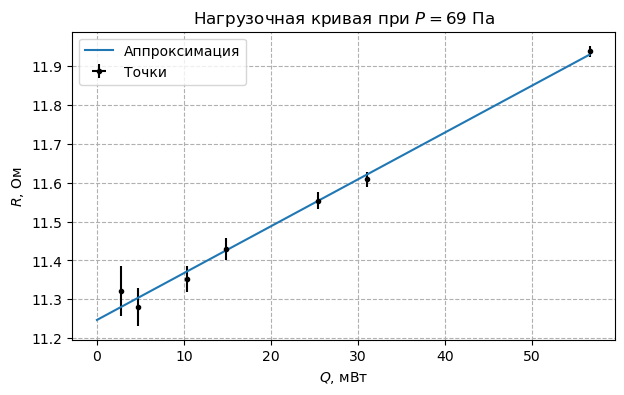

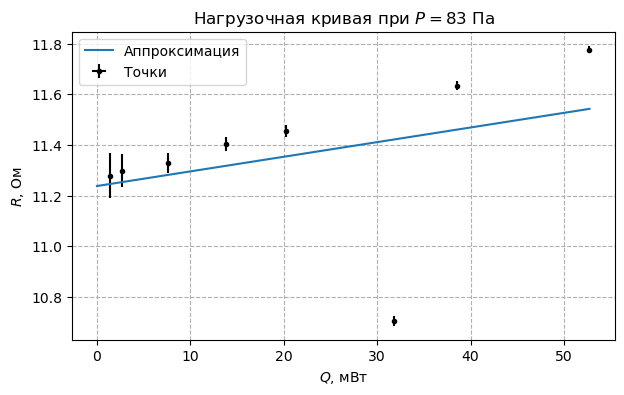

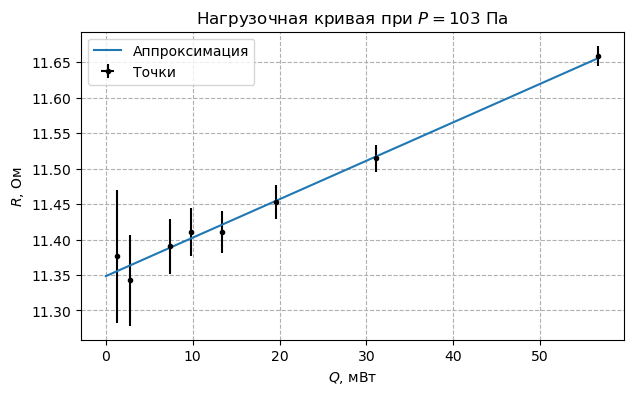

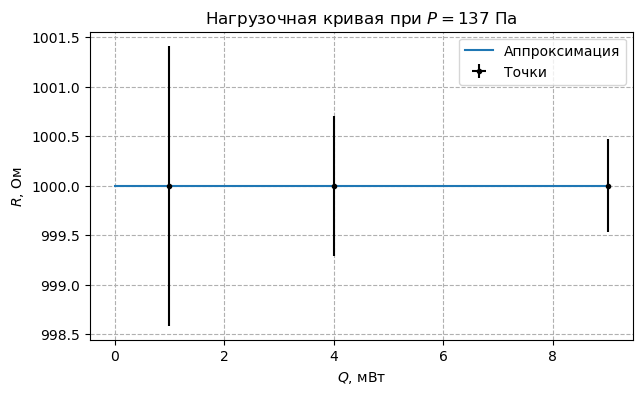

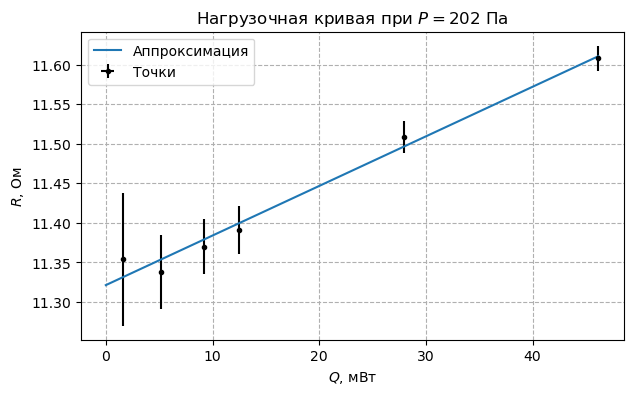

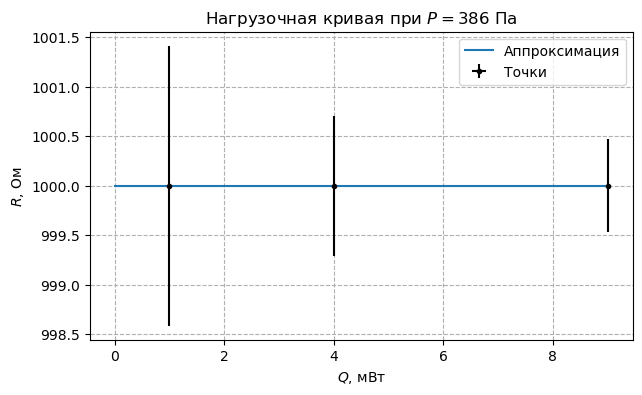

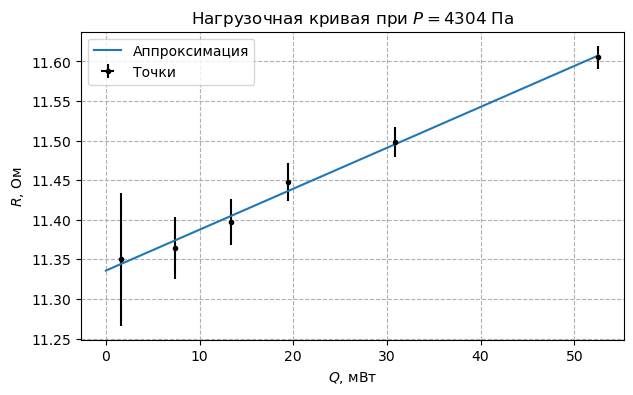

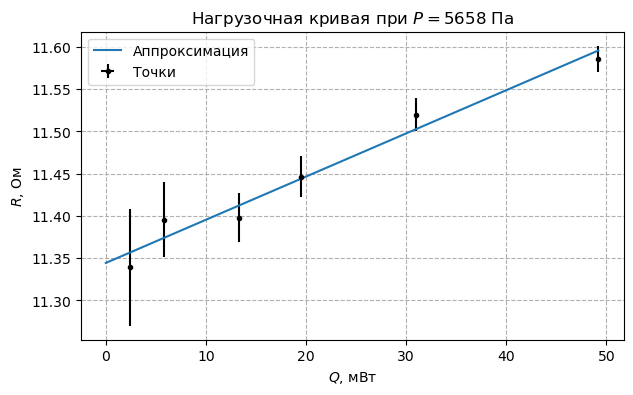

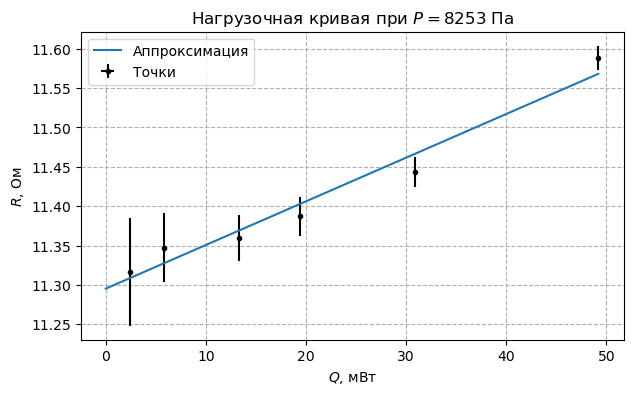

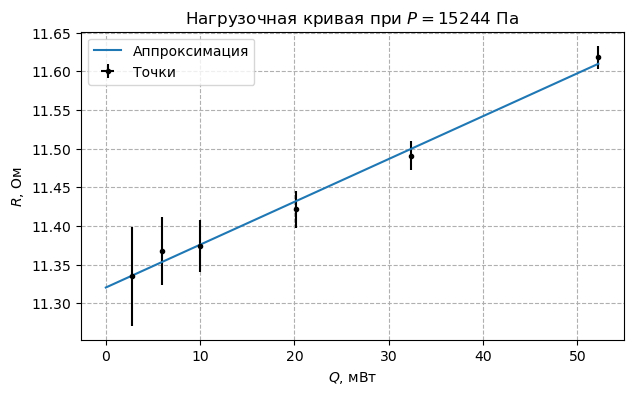

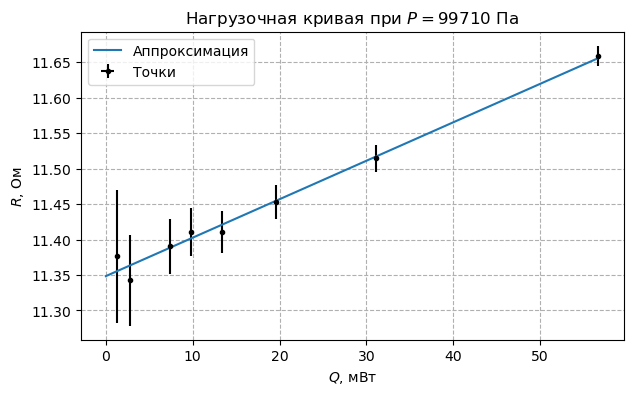

In [173]:
resistances = read_files([f'data/UI{p}.csv' for p in P])

# Погрешности
U_ERR = 0.001
I_ERR = 0.001

a = []
b = []
cnt = 0
with open('include.tex', 'w') as f:
    for resist in resistances:
        resist['R'] = resist['U(V)'] * 1e3 / resist['I(mA)']
        resist[r'$\Delta R$, Ом'] = resist['R'] * [np.sqrt((I_ERR / resist['I(mA)'].iloc[i])**2 + (U_ERR / resist['U(V)'].iloc[i])**2)
                                                   for i in range(resist['I(mA)'].__len__())]
        resist['Q'] = resist['U(V)'] * resist['I(mA)']
        resist[r'$\Delta Q$, мВт'] = resist['Q'] * [np.sqrt((I_ERR / resist['I(mA)'].iloc[i])**2 + (U_ERR / resist['U(V)'].iloc[i])**2)
                                                   for i in range(resist['I(mA)'].__len__())]

        plt.figure(figsize=(7, 4))
        plt.errorbar(resist['Q'], resist['R'], fmt='k.', label='Точки',
                     xerr=resist[r'$\Delta Q$, мВт'], yerr=resist[r'$\Delta R$, Ом'])
        [tmp_a, tmp_b] = np.polyfit(resist['Q'], resist['R'], deg=1)
        a.append(tmp_a)
        b.append(tmp_b)
        x_ax = np.linspace(0, max(resist['Q']), 1000)

        plt.plot(x_ax, tmp_a * x_ax + tmp_b, label='Аппроксимация')

        plt.xlabel('$Q$, мВт')
        plt.ylabel('$R$, Ом')
        plt.title(f'Нагрузочная кривая при $P = {P[cnt]:.0f}$ Па')
        plt.grid(linestyle='--')
        plt.legend()
        plt.savefig(f'graphs/RQ{P[cnt]}.pdf')

        for key in ['Q', 'R', r'$\Delta R$, Ом', r'$\Delta Q$, мВт']:
            resist[key] = resist[key].map(lambda x: '%.2f' % x)

        f.write(latex_tab(resist, f'$P = {P[cnt]:.0f}$ Па'))

        f.write(f'\\begin{{figure}}[H]'
                f'\\centering'
                f'\\includegraphics[width=\\textwidth]{{graphs/RQ{P[cnt]}.pdf}}'
                f'\\end{{figure}}')

        cnt += 1


In [174]:
R_k = b[0]
R_k

11.24695589803776

In [175]:
ALPHA = 3.92e-3
T_K = 27.1

R_0 = R_k / (1 + ALPHA * T_K)
R_0

10.166905222446792

In [176]:
DELTA_T_MAX = 30
R_MAX = R_0 * (1 + ALPHA * (T_K + DELTA_T_MAX))
R_MAX

12.442583952197502